In [150]:
%env CUDA_VISIBLE_DEVICES=0

env: CUDA_VISIBLE_DEVICES=0


In [151]:
from medvqa.utils.files import load_pickle
from medvqa.evaluation.plots import plot_metrics, visualize_image_and_polygons
import numpy as np
import medvqa
import os
from importlib import reload
from medvqa.evaluation.plots import visualize_predicted_bounding_boxes__yolo
from medvqa.datasets.vinbig import VINBIG_BBOX_NAMES__MODIFIED, VINBIG_BBOX_NAMES__MODIFIED
from medvqa.metrics.bbox.utils import compute_mAP__yolov11
from medvqa.utils.logging import print_magenta

In [147]:
reload(medvqa.evaluation.plots)

<module 'medvqa.evaluation.plots' from '/home/pamessina/medvqa/medvqa/evaluation/plots.py'>

In [152]:
# source: https://www.kaggle.com/competitions/vinbigdata-chest-xray-abnormalities-detection/data
VINBIGDATA_CHALLENGE_CLASSES = [
    'Aortic enlargement',
    'Atelectasis',
    'Calcification',
    'Cardiomegaly',
    'Consolidation',
    'ILD',
    'Infiltration',
    'Lung Opacity',
    'Nodule/Mass',
    'Other lesion',
    'Pleural effusion',
    'Pleural thickening',
    'Pneumothorax',
    'Pulmonary fibrosis',
]
assert all(x in VINBIG_BBOX_NAMES__MODIFIED for x in VINBIGDATA_CHALLENGE_CLASSES)

# source: https://github.com/philip-mueller/chex/blob/main/conf/dataset/class_names/vindrcxr_loc_top15.yaml
CHEX_CLASSES = [
    'Aortic enlargement',
    'Atelectasis',
    'Cardiomegaly',
    'Calcification',
    'Consolidation',
    'ILD',
    'Infiltration',
    'Lung Opacity',
    'Mediastinal shift',
    'Nodule/Mass',
    'Pulmonary fibrosis',
    'Pneumothorax',
    'Pleural thickening',
    'Pleural effusion',
    'Other lesion',
]
assert all(x in VINBIG_BBOX_NAMES__MODIFIED for x in CHEX_CLASSES)

# from https://arxiv.org/pdf/2401.10815 (Table 1)
RAD_DINO_CLASSES = [
    'Lung Opacity',
    'Cardiomegaly',
    'Pleural thickening',
    'Aortic enlargement',
    'Pulmonary fibrosis',
    'Tuberculosis',
    'Pleural effusion',
]

ALL_VINBIG_CLASSES = VINBIG_BBOX_NAMES__MODIFIED + ['COPD', 'Lung tumor', 'Pneumonia', 'Tuberculosis', 'Other disease']

CHEX_IOU_THRESHOLDS = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7]

In [153]:
ALL_VINBIG_CLASSES

['Aortic enlargement',
 'Atelectasis',
 'Calcification',
 'Cardiomegaly',
 'Clavicle fracture',
 'Consolidation',
 'Edema',
 'Emphysema',
 'Enlarged PA',
 'ILD',
 'Infiltration',
 'Lung Opacity',
 'Lung cavity',
 'Lung cyst',
 'Mediastinal shift',
 'Nodule/Mass',
 'Other lesion',
 'Pleural effusion',
 'Pleural thickening',
 'Pneumothorax',
 'Pulmonary fibrosis',
 'Rib fracture',
 'Abnormal finding',
 'COPD',
 'Lung tumor',
 'Pneumonia',
 'Tuberculosis',
 'Other disease']

In [9]:
def compute_map_metrics_from_results(results_path, iou_thresholds = [0.0, 0.02, 0.05, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7]):
    results = load_pickle(results_path)
    res = compute_mAP__yolov11(
        gt_coords=results['gt_bboxes'],
        pred_boxes=results['pred_boxes_list'],
        pred_classes=results['pred_classes_list'],
        pred_confs=results['pred_confs_list'],
        classifier_confs=results['classifier_confs'],
        iou_thresholds=iou_thresholds,
        compute_micro_average=True,
    )
    class_aps = res['class_aps']
    micro_aps = res['micro_aps']
        
    for iou_thresh, map_ in zip(iou_thresholds, class_aps.mean(axis=1)):
        print_magenta(f'mAP@{iou_thresh}: {map_}', bold=True)

    for iou_thresh, ap in zip(iou_thresholds, micro_aps):
        print_magenta(f'micro_AP@{iou_thresh}: {ap}', bold=True)
        
    # vinbigdata metric
    class_idxs = [VINBIG_BBOX_NAMES__MODIFIED.index(x) for x in VINBIGDATA_CHALLENGE_CLASSES]
    iou_idx = iou_thresholds.index(0.4)
    mAP = class_aps[iou_idx, class_idxs].mean()
    print_magenta(f'vinbigdata mAP@0.4: {mAP}', bold=True)

    # ChEX metric
    class_idxs = [VINBIG_BBOX_NAMES__MODIFIED.index(x) for x in CHEX_CLASSES]
    iou_idxs = [iou_thresholds.index(x) for x in CHEX_IOU_THRESHOLDS]
    mAP = class_aps[iou_idxs][:, class_idxs].mean()
    print_magenta(f'ChEX mAP@{CHEX_IOU_THRESHOLDS}: {mAP}', bold=True)
    
    # Rad-DINO AUPRC
    print('--- RAD-DINO AUPRC ---')
    prc_auc_per_class = results['prc_auc']['per_class']
    class_idxs = [ALL_VINBIG_CLASSES.index(x) for x in RAD_DINO_CLASSES]
    acc = 0
    count = 0
    for idx, name in zip(class_idxs, RAD_DINO_CLASSES):
        print_magenta(f'AUPRC({name}): {prc_auc_per_class[idx]}', bold=True)
        acc += prc_auc_per_class[idx]
        count += 1
    print_magenta(f'AUPRC(macro average): {acc / count}', bold=True)

In [3]:
def compute_f1_scores_with_bootstrapping(results_path, num_bootstraps=200,
                                          class_names=['Pleural effusion', 'Lung tumor', 'Pneumonia', 'Tuberculosis', 'Other disease', 'No finding']):
    tmp = load_pickle(results_path)
    class_idxs = [tmp['classification']['classification_label_names'].index(x) for x in class_names]
    pred_probs = tmp['classification']['pred_probs'][:, class_idxs]
    gt_labels = tmp['classification']['gt_labels'][:, class_idxs]
    
    from medvqa.utils.metrics import best_threshold_and_f1_score
    from medvqa.evaluation.bootstrapping import stratified_multilabel_bootstrap_metrics
    
    metrics = stratified_multilabel_bootstrap_metrics(
        gt_labels=gt_labels, pred_probs=pred_probs, metric_fn=lambda a, b: best_threshold_and_f1_score(a, b)[1],
        num_bootstraps=num_bootstraps)
    
    for class_name, mean, std in zip(class_names,
                                     metrics['mean_per_class'],
                                     metrics['std_per_class']):
        print(f'F1({class_name}): {mean} ± {std}')
    print(f'F1(macro_avg): {metrics["mean_macro_avg"]} ± {metrics["std_macro_avg"]}')
    print(f'F1(micro_avg): {metrics["mean_micro_avg"]} ± {metrics["std_micro_avg"]}')

In [136]:
def detection_score(i, tmp, verbose=False):

    from medvqa.metrics.bbox.utils import calculate_exact_iou_union
    
    key = 'detection'
    if key not in tmp:
        key = 'bbox_regression' # backward compatibility

    gt_bbox_coords = tmp[key]['gt_bboxes'][i]

    num_gt_bboxes = 0
    for bboxes in gt_bbox_coords:
        num_gt_bboxes += len(bboxes)
    
    if num_gt_bboxes == 0:
        return 0

    pred_coords = tmp[key]['pred_boxes_list'][i]
    pred_classes = tmp[key]['pred_classes_list'][i]
    pred_confs = tmp[key]['pred_confs_list'][i]

    nc = len(gt_bbox_coords)

    absent_acc_prob = 0
    absent_count = 0
    present_acc_iou = 0
    present_count = 0

    for c in range(nc):
        c_idxs = [i for i, x in enumerate(pred_classes) if x == c]
        gt_bboxes = gt_bbox_coords[c]

        if len(gt_bboxes) == 0: # absent
            if len(c_idxs) == 0:
                absent_acc_prob += 0
            else:
                absent_acc_prob += pred_confs[c_idxs].max()
            absent_count += 1
        else: # present
            present_acc_iou += calculate_exact_iou_union(gt_bboxes, pred_coords[c_idxs])
            present_count += 1

    assert absent_count > 0
    assert present_count > 0

    iou_score = present_acc_iou / present_count
    prob_score = absent_acc_prob / absent_count
    prob_score = 1 - prob_score
    if verbose:
        print(f'iou_score: {iou_score}, prob_score: {prob_score}')
    return iou_score + 5 * prob_score    

In [27]:
!python ../eval_phrase_grounding.py \
--checkpoint_folder_path \
"/mnt/data/pamessina/workspaces/medvqa-workspace/models/phrase_grounding/20250206_110041_mim-facts+vinbig_PhraseGrounder(aehrc-cxrmate-rrg24-uniformer,AdaptiveFiLM_MLP_BBoxRegression,128,256,256-128)" \
--num_workers 3 \
--max_images_per_batch 200 \
--max_phrases_per_batch 2000 \
--max_phrases_per_image 30 \
--optimize_thresholds \
--candidate_iou_thresholds 0.02 0.05 0.1 0.2 0.3 0.4 0.5 \
--candidate_conf_thresholds 0.1 0.2 0.3 0.4 0.5 0.6 0.7 \
--use_classifier_confs_for_map \
--eval_vinbig

script's arguments:
   checkpoint_folder_path: /mnt/data/pamessina/workspaces/medvqa-workspace/models/phrase_grounding/20250206_110041_mim-facts+vinbig_PhraseGrounder(aehrc-cxrmate-rrg24-uniformer,AdaptiveFiLM_MLP_BBoxRegression,128,256,256-128)
   max_images_per_batch: 200
   max_phrases_per_batch: 2000
   max_phrases_per_image: 30
   num_workers: 3
   device: GPU
   mscxr_phrase2embedding_filepath: None
   vinbig_use_training_indices_for_validation: False
   eval_chest_imagenome_gold: False
   eval_mscxr: False
   eval_chexlocalize: False
   eval_vinbig: True
   optimize_thresholds: True
   candidate_iou_thresholds: [0.02, 0.05, 0.1, 0.2, 0.3, 0.4, 0.5]
   candidate_conf_thresholds: [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7]
   map_iou_thresholds: [0.0, 0.02, 0.05, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7]
   use_amp: False
   use_classifier_confs_for_map: True
----- Evaluating model -----
metadata loaded from /mnt/data/pamessina/workspaces/medvqa-workspace/models/phrase_grounding/20250206_110041_

mAP(micro_avg): 0.7081246126894474
mAP(macro_avg): 0.4862790528835021
Using classifier confidences for mAP computation
classifier_confs.shape = (3000, 23)
Finding optimal conf and iou thresholds
conf_th=0.1, iou_th=0.02, mAP=0.23512649848786388 (time_input_processing=2.023930788040161, time_map=4.948515892028809)
conf_th=0.1, iou_th=0.05, mAP=0.2334564082877745 (time_input_processing=1.9565150737762451, time_map=5.546518087387085)
conf_th=0.1, iou_th=0.1, mAP=0.2339516555084387 (time_input_processing=1.9607024192810059, time_map=5.572628021240234)
conf_th=0.1, iou_th=0.2, mAP=0.2391238908923867 (time_input_processing=1.9679601192474365, time_map=6.297833204269409)
conf_th=0.1, iou_th=0.3, mAP=0.23977265466122974 (time_input_processing=1.9518630504608154, time_map=7.069717645645142)
conf_th=0.1, iou_th=0.4, mAP=0.24080075986835467 (time_input_processing=2.23887038230896, time_map=8.058773040771484)
conf_th=0.1, iou_th=0.5, mAP=0.24234204719731445 (time_input_processing=1.952509403228759

Saved metrics to /mnt/data/pamessina/workspaces/medvqa-workspace/results/phrase_grounding/20250206_110041_mim-facts+vinbig_PhraseGrounder(aehrc-cxrmate-rrg24-uniformer,AdaptiveFiLM_MLP_BBoxRegression,128,256,256-128)/vindrcxr_metrics(bbox_regression,3000,opt_thr(0.50,0.30),use_classifier_confs).pkl


In [28]:
compute_map_metrics_from_results('/mnt/data/pamessina/workspaces/medvqa-workspace/results/phrase_grounding/20250206_110041_mim-facts+vinbig_PhraseGrounder(aehrc-cxrmate-rrg24-uniformer,AdaptiveFiLM_MLP_BBoxRegression,128,256,256-128)/vindrcxr_metrics(bbox_regression,3000,opt_thr(0.50,0.30),use_classifier_confs).pkl')

mAP@0.0: 0.44490918627592657
mAP@0.02: 0.4046813142841387
mAP@0.05: 0.36684369668133404
mAP@0.1: 0.3076695577168264
mAP@0.2: 0.21961346373963023
mAP@0.3: 0.1664821458407247
mAP@0.4: 0.12337829075425259
mAP@0.5: 0.09315980964517223
mAP@0.6: 0.07058428017780337
mAP@0.7: 0.05964134655270715
micro_AP@0.0: 0.719890291843134
micro_AP@0.02: 0.6633950876271443
micro_AP@0.05: 0.614748145341402
micro_AP@0.1: 0.5467630400300153
micro_AP@0.2: 0.4278296778021544
micro_AP@0.3: 0.32871030720907557
micro_AP@0.4: 0.22721398201257653
micro_AP@0.5: 0.1383344245850166
micro_AP@0.6: 0.08299676195475933
micro_AP@0.7: 0.05810213172853609
vinbigdata mAP@0.4: 0.16220632603989132
ChEX mAP@[0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7]: 0.18367921545245786
--- RAD-DINO AUPRC ---
AUPRC(Lung Opacity): 0.8928469658502749
AUPRC(Cardiomegaly): 0.7934217296127722
AUPRC(Pleural thickening): 0.5299483409028003
AUPRC(Aortic enlargement): 0.49463859073776856
AUPRC(Pulmonary fibrosis): 0.6093044783907519
AUPRC(Tuberculosis): 0.750692

In [64]:
!python ../eval_phrase_grounding.py \
--checkpoint_folder_path \
"/mnt/data/pamessina/workspaces/medvqa-workspace/models/phrase_grounding/20250217_005354_mim-facts+vinbig_PhraseGrounder(aehrc-cxrmate-rrg24-uniformer,AdaptiveFiLM_MLP_BBoxRegression,128,256,256-128)" \
--num_workers 3 \
--max_images_per_batch 200 \
--max_phrases_per_batch 2000 \
--max_phrases_per_image 30 \
--optimize_thresholds \
--candidate_iou_thresholds 0.05 0.1 0.2 0.3 0.4 0.5 \
--candidate_conf_thresholds 0.1 0.2 0.3 0.4 0.5 0.6 \
--use_classifier_confs_for_map \
--eval_vinbig

script's arguments:
   checkpoint_folder_path: /mnt/data/pamessina/workspaces/medvqa-workspace/models/phrase_grounding/20250217_005354_mim-facts+vinbig_PhraseGrounder(aehrc-cxrmate-rrg24-uniformer,AdaptiveFiLM_MLP_BBoxRegression,128,256,256-128)
   max_images_per_batch: 200
   max_phrases_per_batch: 2000
   max_phrases_per_image: 30
   num_workers: 3
   device: GPU
   mscxr_phrase2embedding_filepath: None
   vinbig_use_training_indices_for_validation: False
   checkpoint_folder_path_to_borrow_metadata_from: None
   eval_chest_imagenome_gold: False
   eval_mscxr: False
   eval_chexlocalize: False
   eval_vinbig: True
   optimize_thresholds: True
   candidate_iou_thresholds: [0.05, 0.1, 0.2, 0.3, 0.4, 0.5]
   candidate_conf_thresholds: [0.1, 0.2, 0.3, 0.4, 0.5, 0.6]
   map_iou_thresholds: [0.0, 0.02, 0.05, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7]
   use_amp: False
   use_classifier_confs_for_map: True
----- Evaluating model -----
metadata loaded from /mnt/data/pamessina/workspaces/medvqa-works

Using classifier confidences for mAP computation
classifier_confs.shape = (3000, 23)
Finding optimal conf and iou thresholds
conf_th=0.1, iou_th=0.05, mAP=0.2448276818431375 (time_input_processing=2.3928520679473877, time_map=5.907409191131592)
conf_th=0.1, iou_th=0.1, mAP=0.24735076493924632 (time_input_processing=2.3208858966827393, time_map=6.668203115463257)
conf_th=0.1, iou_th=0.2, mAP=0.25079938909484173 (time_input_processing=2.291201591491699, time_map=7.228473424911499)
conf_th=0.1, iou_th=0.3, mAP=0.2548120440737657 (time_input_processing=2.2951436042785645, time_map=8.174375295639038)
conf_th=0.1, iou_th=0.4, mAP=0.2579008577513924 (time_input_processing=2.302666425704956, time_map=9.527540922164917)
conf_th=0.1, iou_th=0.5, mAP=0.26045217678395927 (time_input_processing=2.3046226501464844, time_map=10.42483639717102)
conf_th=0.2, iou_th=0.05, mAP=0.2452034148712428 (time_input_processing=2.1280949115753174, time_map=5.491751194000244)
conf_th=0.2, iou_th=0.1, mAP=0.24879454

In [74]:
!python ../eval_phrase_grounding.py \
--checkpoint_folder_path \
"/mnt/data/pamessina/workspaces/medvqa-workspace/models/phrase_grounding/20250212_050157_mim-facts+vinbig_PhraseGrounder(facebook-convnext-small-224,AdaptiveFiLM_MLP_BBoxRegression,128,256,256-128)" \
--num_workers 3 \
--max_images_per_batch 200 \
--max_phrases_per_batch 2000 \
--max_phrases_per_image 30 \
--optimize_thresholds \
--candidate_iou_thresholds 0.05 0.1 0.2 0.3 0.4 0.5 \
--candidate_conf_thresholds 0.1 0.2 0.3 0.4 0.5 \
--use_classifier_confs_for_map \
--eval_vinbig

script's arguments:
   checkpoint_folder_path: /mnt/data/pamessina/workspaces/medvqa-workspace/models/phrase_grounding/20250212_050157_mim-facts+vinbig_PhraseGrounder(facebook-convnext-small-224,AdaptiveFiLM_MLP_BBoxRegression,128,256,256-128)
   max_images_per_batch: 200
   max_phrases_per_batch: 2000
   max_phrases_per_image: 30
   num_workers: 3
   device: GPU
   mscxr_phrase2embedding_filepath: None
   vinbig_use_training_indices_for_validation: False
   checkpoint_folder_path_to_borrow_metadata_from: None
   eval_chest_imagenome_gold: False
   eval_mscxr: False
   eval_chexlocalize: False
   eval_vinbig: True
   optimize_thresholds: True
   candidate_iou_thresholds: [0.05, 0.1, 0.2, 0.3, 0.4, 0.5]
   candidate_conf_thresholds: [0.1, 0.2, 0.3, 0.4, 0.5]
   map_iou_thresholds: [0.0, 0.02, 0.05, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7]
   use_amp: False
   use_classifier_confs_for_map: True
Activating determinism(seed=42)...
----- Evaluating model -----
metadata loaded from /mnt/data/pames

Using classifier confidences for mAP computation
classifier_confs.shape = (3000, 23)
Finding optimal conf and iou thresholds
conf_th=0.1, iou_th=0.05, mAP=0.24024638409924107 (time_input_processing=2.3042664527893066, time_map=4.242108583450317)
conf_th=0.1, iou_th=0.1, mAP=0.2398101806361266 (time_input_processing=2.2380597591400146, time_map=4.543599605560303)
conf_th=0.1, iou_th=0.2, mAP=0.2394495770711523 (time_input_processing=2.2378616333007812, time_map=5.1173415184021)
conf_th=0.1, iou_th=0.3, mAP=0.23879859450580593 (time_input_processing=2.5143964290618896, time_map=5.796750783920288)
conf_th=0.1, iou_th=0.4, mAP=0.23952900797430526 (time_input_processing=2.241281032562256, time_map=6.612432241439819)
conf_th=0.1, iou_th=0.5, mAP=0.2375937912212363 (time_input_processing=2.2537035942077637, time_map=7.833125352859497)
conf_th=0.2, iou_th=0.05, mAP=0.24071248998044403 (time_input_processing=2.0830328464508057, time_map=4.309209585189819)
conf_th=0.2, iou_th=0.1, mAP=0.24006413

In [67]:
!python ../eval_phrase_grounding.py \
--checkpoint_folder_path \
"/mnt/data/pamessina/workspaces/medvqa-workspace/models/phrase_grounding/20250212_145548_vinbig_PhraseGrounder(facebook-convnext-small-224,AdaptiveFiLM_MLP_BBoxRegression,128,256,256-128)" \
--num_workers 3 \
--max_images_per_batch 200 \
--max_phrases_per_batch 2000 \
--max_phrases_per_image 30 \
--optimize_thresholds \
--candidate_iou_thresholds 0.05 0.1 0.2 0.3 0.4 0.5 \
--candidate_conf_thresholds 0.1 0.2 0.3 0.4 0.5 \
--use_classifier_confs_for_map \
--eval_vinbig

script's arguments:
   checkpoint_folder_path: /mnt/data/pamessina/workspaces/medvqa-workspace/models/phrase_grounding/20250212_145548_vinbig_PhraseGrounder(facebook-convnext-small-224,AdaptiveFiLM_MLP_BBoxRegression,128,256,256-128)
   max_images_per_batch: 200
   max_phrases_per_batch: 2000
   max_phrases_per_image: 30
   num_workers: 3
   device: GPU
   mscxr_phrase2embedding_filepath: None
   vinbig_use_training_indices_for_validation: False
   checkpoint_folder_path_to_borrow_metadata_from: None
   eval_chest_imagenome_gold: False
   eval_mscxr: False
   eval_chexlocalize: False
   eval_vinbig: True
   optimize_thresholds: True
   candidate_iou_thresholds: [0.05, 0.1, 0.2, 0.3, 0.4, 0.5]
   candidate_conf_thresholds: [0.1, 0.2, 0.3, 0.4, 0.5]
   map_iou_thresholds: [0.0, 0.02, 0.05, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7]
   use_amp: False
   use_classifier_confs_for_map: True
----- Evaluating model -----
metadata loaded from /mnt/data/pamessina/workspaces/medvqa-workspace/models/phras

Using classifier confidences for mAP computation
classifier_confs.shape = (3000, 23)
Finding optimal conf and iou thresholds
conf_th=0.1, iou_th=0.05, mAP=0.2464917829892446 (time_input_processing=2.316096782684326, time_map=4.12809944152832)
conf_th=0.1, iou_th=0.1, mAP=0.24765341167316327 (time_input_processing=2.2501347064971924, time_map=4.407240867614746)
conf_th=0.1, iou_th=0.2, mAP=0.24864615616874303 (time_input_processing=2.234236240386963, time_map=4.885609865188599)
conf_th=0.1, iou_th=0.3, mAP=0.24887363538349158 (time_input_processing=2.232900857925415, time_map=5.791457891464233)
conf_th=0.1, iou_th=0.4, mAP=0.2455113429233709 (time_input_processing=2.2361087799072266, time_map=6.322182655334473)
conf_th=0.1, iou_th=0.5, mAP=0.24032559422199018 (time_input_processing=2.278132677078247, time_map=7.3966965675354)
conf_th=0.2, iou_th=0.05, mAP=0.24649618196041376 (time_input_processing=2.0866174697875977, time_map=3.823184013366699)
conf_th=0.2, iou_th=0.1, mAP=0.24766295610

In [6]:
compute_f1_scores_with_bootstrapping('/mnt/data/pamessina/workspaces/medvqa-workspace/results/phrase_grounding/20250212_145548_vinbig_PhraseGrounder(facebook-convnext-small-224,AdaptiveFiLM_MLP_BBoxRegression,128,256,256-128)/vindrcxr_metrics(bbox_regression,3000,opt_thr(0.30,0.10),use_classifier_confs).pkl')

Bootstrapping: 100%|██████████████████████████████████████████████████████████████████| 200/200 [00:35<00:00,  5.71it/s]

F1(Pleural effusion): 0.776732852844695 ± 0.030973648575825654
F1(Lung tumor): 0.6194693602229752 ± 0.04471006533543247
F1(Pneumonia): 0.6949233549760224 ± 0.02150153174396325
F1(Tuberculosis): 0.6850283793505129 ± 0.028529513073069973
F1(Other disease): 0.6934947498133235 ± 0.013523541426384032
F1(No finding): 0.9340923312998051 ± 0.004000515018697383
F1(macro_avg): 0.7339568380845557 ± 0.01079908764803392
F1(micro_avg): 0.8268537661594153 ± 0.0061053937811923475


In [70]:
!python ../eval_phrase_grounding.py \
--checkpoint_folder_path \
"/mnt/data/pamessina/workspaces/medvqa-workspace/models/phrase_grounding/20250210_234947_mim-facts+vinbig_PhraseGrounder(microsoft-rad-dino-maira-2,AdaptiveFiLM_MLP_BBoxRegression,128,256,256-128)" \
--num_workers 3 \
--max_images_per_batch 50 \
--max_phrases_per_batch 2000 \
--max_phrases_per_image 30 \
--optimize_thresholds \
--candidate_iou_thresholds 0.05 0.1 0.2 0.3 0.4 0.5 \
--candidate_conf_thresholds 0.1 0.2 0.3 0.4 0.5 \
--use_classifier_confs_for_map \
--eval_vinbig

script's arguments:
   checkpoint_folder_path: /mnt/data/pamessina/workspaces/medvqa-workspace/models/phrase_grounding/20250210_234947_mim-facts+vinbig_PhraseGrounder(microsoft-rad-dino-maira-2,AdaptiveFiLM_MLP_BBoxRegression,128,256,256-128)
   max_images_per_batch: 50
   max_phrases_per_batch: 2000
   max_phrases_per_image: 30
   num_workers: 3
   device: GPU
   mscxr_phrase2embedding_filepath: None
   vinbig_use_training_indices_for_validation: False
   checkpoint_folder_path_to_borrow_metadata_from: None
   eval_chest_imagenome_gold: False
   eval_mscxr: False
   eval_chexlocalize: False
   eval_vinbig: True
   optimize_thresholds: True
   candidate_iou_thresholds: [0.05, 0.1, 0.2, 0.3, 0.4, 0.5]
   candidate_conf_thresholds: [0.1, 0.2, 0.3, 0.4, 0.5]
   map_iou_thresholds: [0.0, 0.02, 0.05, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7]
   use_amp: False
   use_classifier_confs_for_map: True
Activating determinism(seed=42)...
----- Evaluating model -----
metadata loaded from /mnt/data/pamessi

Using classifier confidences for mAP computation
classifier_confs.shape = (3000, 23)
Finding optimal conf and iou thresholds
conf_th=0.1, iou_th=0.05, mAP=0.26675039167025094 (time_input_processing=2.121574878692627, time_map=3.223712205886841)
conf_th=0.1, iou_th=0.1, mAP=0.2673168935888361 (time_input_processing=1.5158581733703613, time_map=3.3005776405334473)
conf_th=0.1, iou_th=0.2, mAP=0.2675382707029154 (time_input_processing=1.5027706623077393, time_map=3.7008650302886963)
conf_th=0.1, iou_th=0.3, mAP=0.26471203461747467 (time_input_processing=2.2249648571014404, time_map=4.158709764480591)
conf_th=0.1, iou_th=0.4, mAP=0.26428894714806717 (time_input_processing=2.269839286804199, time_map=4.519296169281006)
conf_th=0.1, iou_th=0.5, mAP=0.26386896825238493 (time_input_processing=2.2664883136749268, time_map=5.366902589797974)
conf_th=0.2, iou_th=0.05, mAP=0.26667803765295905 (time_input_processing=2.186311960220337, time_map=3.4517526626586914)
conf_th=0.2, iou_th=0.1, mAP=0.2672

In [20]:
!python ../eval_phrase_grounding.py \
--checkpoint_folder_path \
"/mnt/data/pamessina/workspaces/medvqa-workspace/models/phrase_grounding/20250211_211631_vinbig_PhraseGrounder(microsoft-rad-dino-maira-2,AdaptiveFiLM_MLP_BBoxRegression,128,256,256-128)" \
--num_workers 3 \
--max_images_per_batch 50 \
--max_phrases_per_batch 2000 \
--max_phrases_per_image 30 \
--optimize_thresholds \
--candidate_iou_thresholds 0.02 0.05 0.1 0.2 0.3 0.4 0.5 \
--candidate_conf_thresholds 0.1 0.2 0.3 0.4 0.5 0.6 0.7 \
--use_classifier_confs_for_map \
--eval_vinbig

script's arguments:
   checkpoint_folder_path: /mnt/data/pamessina/workspaces/medvqa-workspace/models/phrase_grounding/20250211_211631_vinbig_PhraseGrounder(microsoft-rad-dino-maira-2,AdaptiveFiLM_MLP_BBoxRegression,128,256,256-128)
   max_images_per_batch: 50
   max_phrases_per_batch: 2000
   max_phrases_per_image: 30
   num_workers: 3
   device: GPU
   mscxr_phrase2embedding_filepath: None
   vinbig_use_training_indices_for_validation: False
   eval_chest_imagenome_gold: False
   eval_mscxr: False
   eval_chexlocalize: False
   eval_vinbig: True
   optimize_thresholds: True
   candidate_iou_thresholds: [0.02, 0.05, 0.1, 0.2, 0.3, 0.4, 0.5]
   candidate_conf_thresholds: [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7]
   map_iou_thresholds: [0.0, 0.02, 0.05, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7]
   use_amp: False
   use_classifier_confs_for_map: True
----- Evaluating model -----
metadata loaded from /mnt/data/pamessina/workspaces/medvqa-workspace/models/phrase_grounding/20250211_211631_vinbig_PhraseG

mAP(micro_avg): 0.6201757404543735
mAP(macro_avg): 0.4205933935233076
Using classifier confidences for mAP computation
classifier_confs.shape = (3000, 23)
Finding optimal conf and iou thresholds
conf_th=0.1, iou_th=0.02, mAP=0.2498399736550639 (time_input_processing=1.9016032218933105, time_map=3.4472463130950928)
conf_th=0.1, iou_th=0.05, mAP=0.249976998605055 (time_input_processing=1.8543658256530762, time_map=3.533987522125244)
conf_th=0.1, iou_th=0.1, mAP=0.2496794055687174 (time_input_processing=1.8903942108154297, time_map=3.6027064323425293)
conf_th=0.1, iou_th=0.2, mAP=0.25297691137671546 (time_input_processing=1.8464713096618652, time_map=4.0916056632995605)
conf_th=0.1, iou_th=0.3, mAP=0.25232310819474696 (time_input_processing=1.83087158203125, time_map=4.09166145324707)
conf_th=0.1, iou_th=0.4, mAP=0.25321919264542986 (time_input_processing=1.8504891395568848, time_map=4.537095069885254)
conf_th=0.1, iou_th=0.5, mAP=0.25316105886442947 (time_input_processing=1.8630952835083

Saved metrics to /mnt/data/pamessina/workspaces/medvqa-workspace/results/phrase_grounding/20250211_211631_vinbig_PhraseGrounder(microsoft-rad-dino-maira-2,AdaptiveFiLM_MLP_BBoxRegression,128,256,256-128)/vindrcxr_metrics(bbox_regression,3000,opt_thr(0.40,0.10),use_classifier_confs).pkl


In [21]:
compute_map_metrics_from_results('/mnt/data/pamessina/workspaces/medvqa-workspace/results/phrase_grounding/20250211_211631_vinbig_PhraseGrounder(microsoft-rad-dino-maira-2,AdaptiveFiLM_MLP_BBoxRegression,128,256,256-128)/vindrcxr_metrics(bbox_regression,3000,opt_thr(0.40,0.10),use_classifier_confs).pkl')

mAP@0.0: 0.38538002409818584
mAP@0.02: 0.3568662549013816
mAP@0.05: 0.339128981388419
mAP@0.1: 0.3120560088547995
mAP@0.2: 0.25372650793472346
mAP@0.3: 0.20350779252554702
mAP@0.4: 0.16730940390244076
mAP@0.5: 0.13527491502364536
mAP@0.6: 0.10549988550657352
mAP@0.7: 0.08479144206567317
micro_AP@0.0: 0.6334956764029142
micro_AP@0.02: 0.5871714998935624
micro_AP@0.05: 0.5604575988812315
micro_AP@0.1: 0.5253810992063853
micro_AP@0.2: 0.4421062323815359
micro_AP@0.3: 0.35764435017014273
micro_AP@0.4: 0.27569526824507223
micro_AP@0.5: 0.18649526531137828
micro_AP@0.6: 0.123731027039795
micro_AP@0.7: 0.07773586393236079
vinbigdata mAP@0.4: 0.19864325260125337
ChEX mAP@[0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7]: 0.21153520056612785
--- RAD-DINO AUPRC ---
AUPRC(Lung Opacity): 0.8298892092087947
AUPRC(Cardiomegaly): 0.7192670780805038
AUPRC(Pleural thickening): 0.3390474333497303
AUPRC(Aortic enlargement): 0.37062223376493886
AUPRC(Pulmonary fibrosis): 0.5242330719034994
AUPRC(Tuberculosis): 0.634271

In [71]:
!python ../eval_phrase_grounding.py \
--checkpoint_folder_path \
"/mnt/data/pamessina/workspaces/medvqa-workspace/models/phrase_grounding/20250217_080237_vinbig_PhraseGrounder(microsoft-rad-dino-maira-2,AdaptiveFiLM_MLP_BBoxRegression,128,256,256-128)" \
--num_workers 3 \
--max_images_per_batch 50 \
--max_phrases_per_batch 2000 \
--max_phrases_per_image 30 \
--optimize_thresholds \
--candidate_iou_thresholds 0.05 0.1 0.2 0.3 0.4 0.5 \
--candidate_conf_thresholds 0.1 0.2 0.3 0.4 0.5 \
--use_classifier_confs_for_map \
--eval_vinbig

script's arguments:
   checkpoint_folder_path: /mnt/data/pamessina/workspaces/medvqa-workspace/models/phrase_grounding/20250217_080237_vinbig_PhraseGrounder(microsoft-rad-dino-maira-2,AdaptiveFiLM_MLP_BBoxRegression,128,256,256-128)
   max_images_per_batch: 50
   max_phrases_per_batch: 2000
   max_phrases_per_image: 30
   num_workers: 3
   device: GPU
   mscxr_phrase2embedding_filepath: None
   vinbig_use_training_indices_for_validation: False
   checkpoint_folder_path_to_borrow_metadata_from: None
   eval_chest_imagenome_gold: False
   eval_mscxr: False
   eval_chexlocalize: False
   eval_vinbig: True
   optimize_thresholds: True
   candidate_iou_thresholds: [0.05, 0.1, 0.2, 0.3, 0.4, 0.5]
   candidate_conf_thresholds: [0.1, 0.2, 0.3, 0.4, 0.5]
   map_iou_thresholds: [0.0, 0.02, 0.05, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7]
   use_amp: False
   use_classifier_confs_for_map: True
Activating determinism(seed=42)...
----- Evaluating model -----
metadata loaded from /mnt/data/pamessina/workspa

Using classifier confidences for mAP computation
classifier_confs.shape = (3000, 23)
Finding optimal conf and iou thresholds
conf_th=0.1, iou_th=0.05, mAP=0.2660422744198832 (time_input_processing=2.2021541595458984, time_map=3.5086514949798584)
conf_th=0.1, iou_th=0.1, mAP=0.2661578220597055 (time_input_processing=2.1321730613708496, time_map=3.6388604640960693)
conf_th=0.1, iou_th=0.2, mAP=0.26559467826421324 (time_input_processing=2.1169464588165283, time_map=3.8197269439697266)
conf_th=0.1, iou_th=0.3, mAP=0.2654043743099036 (time_input_processing=2.418713331222534, time_map=4.080850124359131)
conf_th=0.1, iou_th=0.4, mAP=0.2655546175500443 (time_input_processing=2.146580696105957, time_map=4.465182781219482)
conf_th=0.1, iou_th=0.5, mAP=0.26546050403381594 (time_input_processing=2.149925470352173, time_map=4.960587739944458)
conf_th=0.2, iou_th=0.05, mAP=0.26578167965125093 (time_input_processing=2.0597105026245117, time_map=3.6789965629577637)
conf_th=0.2, iou_th=0.1, mAP=0.26584

In [22]:
!python ../eval_phrase_grounding.py \
--checkpoint_folder_path \
"/mnt/data/pamessina/workspaces/medvqa-workspace/models/phrase_grounding/20250210_112136_vinbig_PhraseGrounder(aehrc-cxrmate-rrg24-uniformer,AdaptiveFiLM_MLP_BBoxRegression,128,256,256-128)" \
--num_workers 3 \
--max_images_per_batch 200 \
--max_phrases_per_batch 2000 \
--max_phrases_per_image 30 \
--optimize_thresholds \
--candidate_iou_thresholds 0.02 0.05 0.1 0.2 0.3 0.4 0.5 \
--candidate_conf_thresholds 0.1 0.2 0.3 0.4 0.5 0.6 0.7 \
--use_classifier_confs_for_map \
--eval_vinbig

script's arguments:
   checkpoint_folder_path: /mnt/data/pamessina/workspaces/medvqa-workspace/models/phrase_grounding/20250210_112136_vinbig_PhraseGrounder(aehrc-cxrmate-rrg24-uniformer,AdaptiveFiLM_MLP_BBoxRegression,128,256,256-128)
   max_images_per_batch: 200
   max_phrases_per_batch: 2000
   max_phrases_per_image: 30
   num_workers: 3
   device: GPU
   mscxr_phrase2embedding_filepath: None
   vinbig_use_training_indices_for_validation: False
   eval_chest_imagenome_gold: False
   eval_mscxr: False
   eval_chexlocalize: False
   eval_vinbig: True
   optimize_thresholds: True
   candidate_iou_thresholds: [0.02, 0.05, 0.1, 0.2, 0.3, 0.4, 0.5]
   candidate_conf_thresholds: [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7]
   map_iou_thresholds: [0.0, 0.02, 0.05, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7]
   use_amp: False
   use_classifier_confs_for_map: True
----- Evaluating model -----
metadata loaded from /mnt/data/pamessina/workspaces/medvqa-workspace/models/phrase_grounding/20250210_112136_vinbig_Phr

mAP(micro_avg): 0.7147914046661619
mAP(macro_avg): 0.4937180789170251
Using classifier confidences for mAP computation
classifier_confs.shape = (3000, 23)
Finding optimal conf and iou thresholds
conf_th=0.1, iou_th=0.02, mAP=0.2582360189317714 (time_input_processing=1.7887206077575684, time_map=3.816784381866455)
conf_th=0.1, iou_th=0.05, mAP=0.25977660487682724 (time_input_processing=1.7172157764434814, time_map=3.972350835800171)
conf_th=0.1, iou_th=0.1, mAP=0.2636826573600857 (time_input_processing=1.9780993461608887, time_map=4.2060465812683105)
conf_th=0.1, iou_th=0.2, mAP=0.2670520999294734 (time_input_processing=1.6956658363342285, time_map=4.706671953201294)
conf_th=0.1, iou_th=0.3, mAP=0.2653712939503384 (time_input_processing=1.7005105018615723, time_map=5.285444021224976)
conf_th=0.1, iou_th=0.4, mAP=0.2671404254602458 (time_input_processing=1.7245254516601562, time_map=6.0603742599487305)
conf_th=0.1, iou_th=0.5, mAP=0.2651463063479199 (time_input_processing=1.7298009395599

Saved metrics to /mnt/data/pamessina/workspaces/medvqa-workspace/results/phrase_grounding/20250210_112136_vinbig_PhraseGrounder(aehrc-cxrmate-rrg24-uniformer,AdaptiveFiLM_MLP_BBoxRegression,128,256,256-128)/vindrcxr_metrics(bbox_regression,3000,opt_thr(0.20,0.40),use_classifier_confs).pkl


In [23]:
compute_map_metrics_from_results('/mnt/data/pamessina/workspaces/medvqa-workspace/results/phrase_grounding/20250210_112136_vinbig_PhraseGrounder(aehrc-cxrmate-rrg24-uniformer,AdaptiveFiLM_MLP_BBoxRegression,128,256,256-128)/vindrcxr_metrics(bbox_regression,3000,opt_thr(0.20,0.40),use_classifier_confs).pkl')

mAP@0.0: 0.45732516190149813
mAP@0.02: 0.4220920648376581
mAP@0.05: 0.38881729182956487
mAP@0.1: 0.3406949129666348
mAP@0.2: 0.26424566377732256
mAP@0.3: 0.20106555541858553
mAP@0.4: 0.14903912826415286
mAP@0.5: 0.11718942137239265
mAP@0.6: 0.08867038760475286
mAP@0.7: 0.06928130405430317
micro_AP@0.0: 0.7151802866844307
micro_AP@0.02: 0.6691376052307739
micro_AP@0.05: 0.6298751415402382
micro_AP@0.1: 0.5681019696749664
micro_AP@0.2: 0.4678463041605867
micro_AP@0.3: 0.3678699658966936
micro_AP@0.4: 0.27678008115026165
micro_AP@0.5: 0.19418310397802968
micro_AP@0.6: 0.11833418474408759
micro_AP@0.7: 0.0763193720659131
vinbigdata mAP@0.4: 0.19077787836319166
ChEX mAP@[0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7]: 0.21421513149409674
--- RAD-DINO AUPRC ---
AUPRC(Lung Opacity): 0.8967358934579414
AUPRC(Cardiomegaly): 0.7879621416723142
AUPRC(Pleural thickening): 0.5157934620498567
AUPRC(Aortic enlargement): 0.4794339519623813
AUPRC(Pulmonary fibrosis): 0.6341820106742889
AUPRC(Tuberculosis): 0.76643

In [65]:
!python ../eval_phrase_grounding.py \
--checkpoint_folder_path \
"/mnt/data/pamessina/workspaces/medvqa-workspace/models/phrase_grounding/20250217_111607_vinbig_PhraseGrounder(aehrc-cxrmate-rrg24-uniformer,AdaptiveFiLM_MLP_BBoxRegression,128,256,256-128)" \
--num_workers 3 \
--max_images_per_batch 200 \
--max_phrases_per_batch 2000 \
--max_phrases_per_image 30 \
--optimize_thresholds \
--candidate_iou_thresholds 0.05 0.1 0.2 0.3 0.4 0.5 \
--candidate_conf_thresholds 0.1 0.2 0.3 0.4 0.5 \
--use_classifier_confs_for_map \
--eval_vinbig

script's arguments:
   checkpoint_folder_path: /mnt/data/pamessina/workspaces/medvqa-workspace/models/phrase_grounding/20250217_111607_vinbig_PhraseGrounder(aehrc-cxrmate-rrg24-uniformer,AdaptiveFiLM_MLP_BBoxRegression,128,256,256-128)
   max_images_per_batch: 200
   max_phrases_per_batch: 2000
   max_phrases_per_image: 30
   num_workers: 3
   device: GPU
   mscxr_phrase2embedding_filepath: None
   vinbig_use_training_indices_for_validation: False
   checkpoint_folder_path_to_borrow_metadata_from: None
   eval_chest_imagenome_gold: False
   eval_mscxr: False
   eval_chexlocalize: False
   eval_vinbig: True
   optimize_thresholds: True
   candidate_iou_thresholds: [0.05, 0.1, 0.2, 0.3, 0.4, 0.5]
   candidate_conf_thresholds: [0.1, 0.2, 0.3, 0.4, 0.5]
   map_iou_thresholds: [0.0, 0.02, 0.05, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7]
   use_amp: False
   use_classifier_confs_for_map: True
----- Evaluating model -----
metadata loaded from /mnt/data/pamessina/workspaces/medvqa-workspace/models/phr

Using classifier confidences for mAP computation
classifier_confs.shape = (3000, 23)
Finding optimal conf and iou thresholds
conf_th=0.1, iou_th=0.05, mAP=0.26482357089706854 (time_input_processing=2.3519034385681152, time_map=4.404831886291504)
conf_th=0.1, iou_th=0.1, mAP=0.2691347462755697 (time_input_processing=2.283517360687256, time_map=5.032220363616943)
conf_th=0.1, iou_th=0.2, mAP=0.26817097528574546 (time_input_processing=2.260000467300415, time_map=5.325573205947876)
conf_th=0.1, iou_th=0.3, mAP=0.26686856830638334 (time_input_processing=2.2993478775024414, time_map=6.053109884262085)
conf_th=0.1, iou_th=0.4, mAP=0.2659387622075351 (time_input_processing=2.289897918701172, time_map=7.346545457839966)
conf_th=0.1, iou_th=0.5, mAP=0.26439339083273067 (time_input_processing=2.3013665676116943, time_map=8.139758348464966)
conf_th=0.2, iou_th=0.05, mAP=0.2696085958528657 (time_input_processing=2.2571756839752197, time_map=4.178012132644653)
conf_th=0.2, iou_th=0.1, mAP=0.27395532

In [4]:
compute_f1_scores_with_bootstrapping('/mnt/data/pamessina/workspaces/medvqa-workspace/results/phrase_grounding/20250217_111607_vinbig_PhraseGrounder(aehrc-cxrmate-rrg24-uniformer,AdaptiveFiLM_MLP_BBoxRegression,128,256,256-128)/vindrcxr_metrics(bbox_regression,3000,opt_thr(0.10,0.30),use_classifier_confs).pkl')

Bootstrapping: 100%|██████████████████████████████████████████████████████████████████| 200/200 [00:38<00:00,  5.21it/s]

F1(Pleural effusion): 0.7808918681030613 ± 0.029379013610796437
F1(Lung tumor): 0.6914494159666664 ± 0.03915471445397005
F1(Pneumonia): 0.7339997886998885 ± 0.020622509162120228
F1(Tuberculosis): 0.7500356392070492 ± 0.026019503110133187
F1(Other disease): 0.7099357771393144 ± 0.012754619628083748
F1(No finding): 0.9495507075892877 ± 0.0032810534099066697
F1(macro_avg): 0.7693105327842114 ± 0.009600784488605324
F1(micro_avg): 0.8393186690865311 ± 0.0052656227973809245


In [154]:
tmp = load_pickle('/mnt/data/pamessina/workspaces/medvqa-workspace/results/phrase_grounding/20250217_111607_vinbig_PhraseGrounder(aehrc-cxrmate-rrg24-uniformer,AdaptiveFiLM_MLP_BBoxRegression,128,256,256-128)/vindrcxr_metrics(bbox_regression,3000,opt_thr(0.10,0.30),use_classifier_confs).pkl')

In [155]:
bbox_names = VINBIG_BBOX_NAMES__MODIFIED[:]
bbox_names.remove('Edema')

0.20529395
image_path=/mnt/workspace/vinbig-cxr/dataset-jpg/images_hq-512x512(keep_aspect_ratio)/e0dc2e79105ad93532484e956ef8a71a.jpg


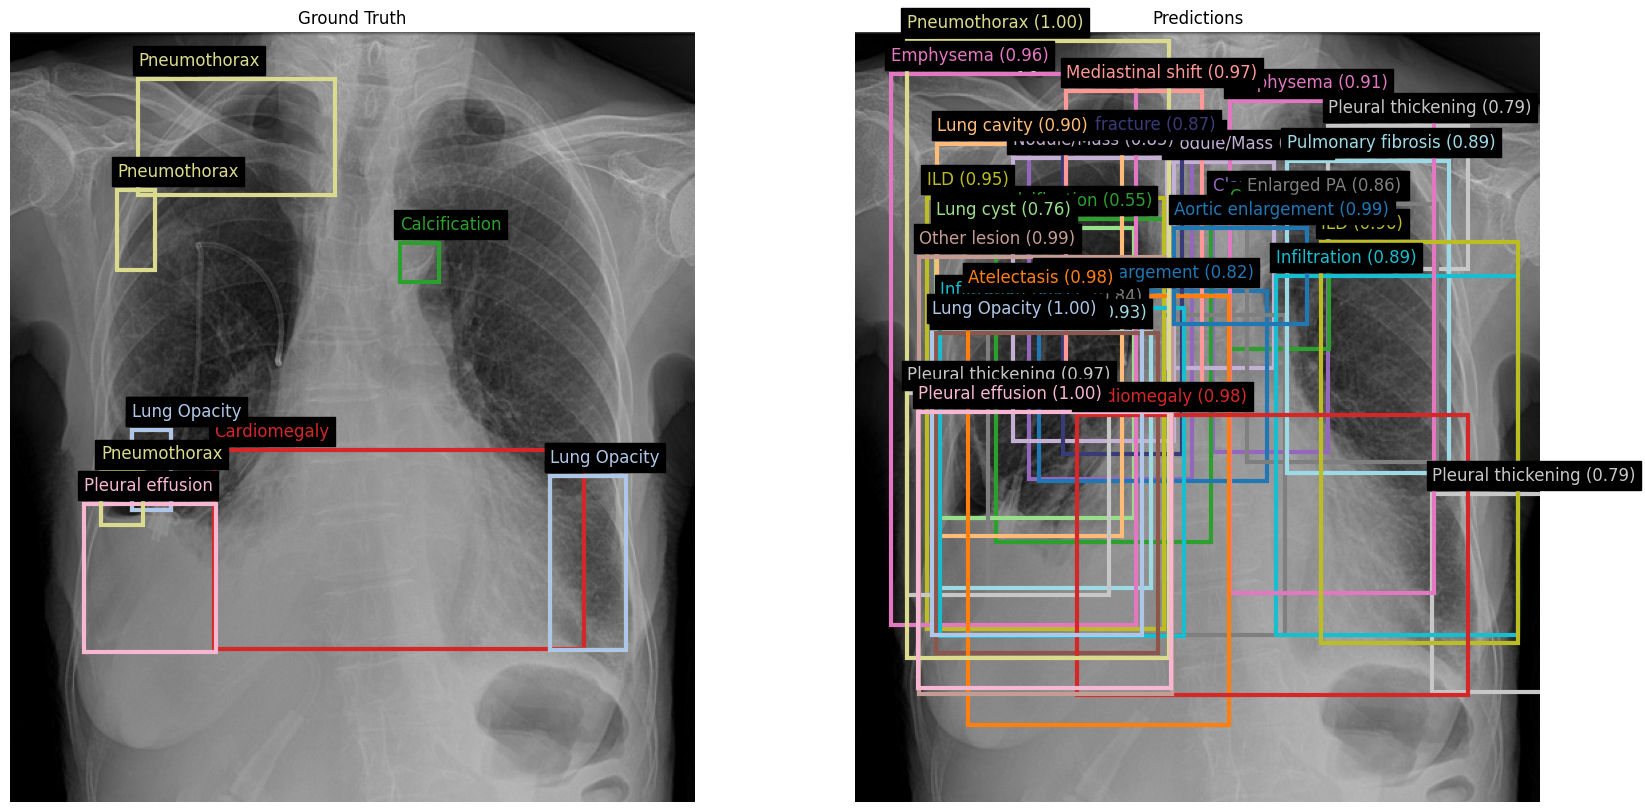

In [158]:
i = 0
key = 'bbox_regression'
print(tmp[key]['sample_ious'][i])
visualize_predicted_bounding_boxes__yolo(
    image_path=tmp['image_paths'][i],
    pred_coords=tmp[key]['pred_boxes_list'][i],
    pred_classes=tmp[key]['pred_classes_list'][i],
    pred_confs=tmp[key]['pred_confs_list'][i],
    gt_bbox_coords=tmp[key]['gt_bboxes'][i],
    class_names=bbox_names,
    figsize=(20, 10),
    format='xyxy',
    classes_to_highlight=[x for x in bbox_names if x != 'Abnormal finding'],
    hide_other_classes=True,
#     minimum_confidence=0.2,
)

In [25]:
!python ../eval_phrase_grounding.py \
--checkpoint_folder_path \
"/mnt/data/pamessina/workspaces/medvqa-workspace/models/phrase_grounding/20250206_175748_mim-facts+vinbig_PhraseGrounder(aehrc-cxrmate-rrg24-uniformer,AdaptiveFiLM_MLP_BBoxRegression,128,256,256-128)" \
--num_workers 3 \
--max_images_per_batch 200 \
--max_phrases_per_batch 2000 \
--max_phrases_per_image 30 \
--optimize_thresholds \
--candidate_iou_thresholds 0.02 0.05 0.1 0.2 0.3 0.4 0.5 \
--candidate_conf_thresholds 0.1 0.2 0.3 0.4 0.5 0.6 0.7 \
--use_classifier_confs_for_map \
--eval_vinbig

script's arguments:
   checkpoint_folder_path: /mnt/data/pamessina/workspaces/medvqa-workspace/models/phrase_grounding/20250206_175748_mim-facts+vinbig_PhraseGrounder(aehrc-cxrmate-rrg24-uniformer,AdaptiveFiLM_MLP_BBoxRegression,128,256,256-128)
   max_images_per_batch: 200
   max_phrases_per_batch: 2000
   max_phrases_per_image: 30
   num_workers: 3
   device: GPU
   mscxr_phrase2embedding_filepath: None
   vinbig_use_training_indices_for_validation: False
   eval_chest_imagenome_gold: False
   eval_mscxr: False
   eval_chexlocalize: False
   eval_vinbig: True
   optimize_thresholds: True
   candidate_iou_thresholds: [0.02, 0.05, 0.1, 0.2, 0.3, 0.4, 0.5]
   candidate_conf_thresholds: [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7]
   map_iou_thresholds: [0.0, 0.02, 0.05, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7]
   use_amp: False
   use_classifier_confs_for_map: True
----- Evaluating model -----
metadata loaded from /mnt/data/pamessina/workspaces/medvqa-workspace/models/phrase_grounding/20250206_175748_

mAP(macro_avg): 0.49138083479813954
Using classifier confidences for mAP computation
classifier_confs.shape = (3000, 23)
Finding optimal conf and iou thresholds
conf_th=0.1, iou_th=0.02, mAP=0.2396776323233414 (time_input_processing=1.9851794242858887, time_map=4.7021050453186035)
conf_th=0.1, iou_th=0.05, mAP=0.24224934597291928 (time_input_processing=1.9109890460968018, time_map=5.203131437301636)
conf_th=0.1, iou_th=0.1, mAP=0.24275607058670537 (time_input_processing=1.8934640884399414, time_map=5.224652051925659)
conf_th=0.1, iou_th=0.2, mAP=0.2501099572914548 (time_input_processing=1.8922100067138672, time_map=5.900353670120239)
conf_th=0.1, iou_th=0.3, mAP=0.2506709227153183 (time_input_processing=1.9007225036621094, time_map=6.612528324127197)
conf_th=0.1, iou_th=0.4, mAP=0.25124196510171964 (time_input_processing=1.8989536762237549, time_map=7.473397731781006)
conf_th=0.1, iou_th=0.5, mAP=0.25139245257479215 (time_input_processing=1.9041543006896973, time_map=8.769822835922241)

Saved metrics to /mnt/data/pamessina/workspaces/medvqa-workspace/results/phrase_grounding/20250206_175748_mim-facts+vinbig_PhraseGrounder(aehrc-cxrmate-rrg24-uniformer,AdaptiveFiLM_MLP_BBoxRegression,128,256,256-128)/vindrcxr_metrics(bbox_regression,3000,opt_thr(0.20,0.30),use_classifier_confs).pkl


In [26]:
compute_map_metrics_from_results('/mnt/data/pamessina/workspaces/medvqa-workspace/results/phrase_grounding/20250206_175748_mim-facts+vinbig_PhraseGrounder(aehrc-cxrmate-rrg24-uniformer,AdaptiveFiLM_MLP_BBoxRegression,128,256,256-128)/vindrcxr_metrics(bbox_regression,3000,opt_thr(0.20,0.30),use_classifier_confs).pkl')

mAP@0.0: 0.46250452823437566
mAP@0.02: 0.40338950142933605
mAP@0.05: 0.37445078115703523
mAP@0.1: 0.32008928004385906
mAP@0.2: 0.2366953109945749
mAP@0.3: 0.17460823180396004
mAP@0.4: 0.1312958736276806
mAP@0.5: 0.09745709000758644
mAP@0.6: 0.07589682772956227
mAP@0.7: 0.05759761890783823
micro_AP@0.0: 0.7166011125740414
micro_AP@0.02: 0.6510572576193346
micro_AP@0.05: 0.6044027417993802
micro_AP@0.1: 0.5413580229575826
micro_AP@0.2: 0.4230118757000388
micro_AP@0.3: 0.30139034816604127
micro_AP@0.4: 0.20401024786931077
micro_AP@0.5: 0.1233445845509486
micro_AP@0.6: 0.08052249441030182
micro_AP@0.7: 0.05645504792983661
vinbigdata mAP@0.4: 0.15844244965026522
ChEX mAP@[0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7]: 0.19044996823038823
--- RAD-DINO AUPRC ---
AUPRC(Lung Opacity): 0.8926180898012651
AUPRC(Cardiomegaly): 0.7770794083447891
AUPRC(Pleural thickening): 0.49265565447842347
AUPRC(Aortic enlargement): 0.4829439564729613
AUPRC(Pulmonary fibrosis): 0.6007932119942497
AUPRC(Tuberculosis): 0.752

In [60]:
!python ../eval_phrase_grounding.py \
--checkpoint_folder_path \
"/mnt/data/pamessina/workspaces/medvqa-workspace/models/phrase_grounding/20250203_061403_vinbig_PhraseGrounder(aehrc-cxrmate-rrg24-uniformer,AdaptiveFiLM_MLP_BBoxRegression,128,256,256-128)" \
--num_workers 3 \
--max_images_per_batch 200 \
--max_phrases_per_batch 2000 \
--max_phrases_per_image 30 \
--optimize_thresholds \
--candidate_iou_thresholds 0.05 0.1 0.2 0.3 0.4 0.5 \
--candidate_conf_thresholds 0.1 0.2 0.3 0.4 0.5 0.6 \
--use_classifier_confs_for_map \
--eval_vinbig

script's arguments:
   checkpoint_folder_path: /mnt/data/pamessina/workspaces/medvqa-workspace/models/phrase_grounding/20250203_061403_vinbig_PhraseGrounder(aehrc-cxrmate-rrg24-uniformer,AdaptiveFiLM_MLP_BBoxRegression,128,256,256-128)
   max_images_per_batch: 200
   max_phrases_per_batch: 2000
   max_phrases_per_image: 30
   num_workers: 3
   device: GPU
   mscxr_phrase2embedding_filepath: None
   vinbig_use_training_indices_for_validation: False
   checkpoint_folder_path_to_borrow_metadata_from: None
   eval_chest_imagenome_gold: False
   eval_mscxr: False
   eval_chexlocalize: False
   eval_vinbig: True
   optimize_thresholds: True
   candidate_iou_thresholds: [0.05, 0.1, 0.2, 0.3, 0.4, 0.5]
   candidate_conf_thresholds: [0.1, 0.2, 0.3, 0.4, 0.5, 0.6]
   map_iou_thresholds: [0.0, 0.02, 0.05, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7]
   use_amp: False
   use_classifier_confs_for_map: True
----- Evaluating model -----
metadata loaded from /mnt/data/pamessina/workspaces/medvqa-workspace/model

Using classifier confidences for mAP computation
classifier_confs.shape = (3000, 23)
Finding optimal conf and iou thresholds
conf_th=0.1, iou_th=0.05, mAP=0.279823815545424 (time_input_processing=1.7900867462158203, time_map=3.729485034942627)
conf_th=0.1, iou_th=0.1, mAP=0.2812149773412564 (time_input_processing=1.7159204483032227, time_map=3.9328174591064453)
conf_th=0.1, iou_th=0.2, mAP=0.28135015668881075 (time_input_processing=1.6987993717193604, time_map=4.614631652832031)
conf_th=0.1, iou_th=0.3, mAP=0.28321814087128716 (time_input_processing=1.6966662406921387, time_map=4.8337695598602295)
conf_th=0.1, iou_th=0.4, mAP=0.2755097679144423 (time_input_processing=1.6970257759094238, time_map=5.401681423187256)
conf_th=0.1, iou_th=0.5, mAP=0.2775852237504558 (time_input_processing=1.7266082763671875, time_map=6.364051103591919)
conf_th=0.2, iou_th=0.05, mAP=0.2776769871632054 (time_input_processing=1.6070444583892822, time_map=3.696384906768799)
conf_th=0.2, iou_th=0.1, mAP=0.280551

In [5]:
tmp = load_pickle('/mnt/data/pamessina/workspaces/medvqa-workspace/results/phrase_grounding/20250203_061403_vinbig_PhraseGrounder(aehrc-cxrmate-rrg24-uniformer,AdaptiveFiLM_MLP_BBoxRegression,128,256,256-128)/vindrcxr_metrics(bbox_regression,3000,opt_thr(0.30,0.10),use_classifier_confs).pkl')

In [137]:
scores = [detection_score(i, tmp) for i in range(len(tmp['bbox_regression']['gt_bboxes']))]
idxs = np.argsort(scores)[::-1]

In [138]:
bbox_names = VINBIG_BBOX_NAMES__MODIFIED[:]
bbox_names.remove('Edema')
bbox_names

['Aortic enlargement',
 'Atelectasis',
 'Calcification',
 'Cardiomegaly',
 'Clavicle fracture',
 'Consolidation',
 'Emphysema',
 'Enlarged PA',
 'ILD',
 'Infiltration',
 'Lung Opacity',
 'Lung cavity',
 'Lung cyst',
 'Mediastinal shift',
 'Nodule/Mass',
 'Other lesion',
 'Pleural effusion',
 'Pleural thickening',
 'Pneumothorax',
 'Pulmonary fibrosis',
 'Rib fracture',
 'Abnormal finding']

In [106]:
classes_to_highlight = bbox_names[:]
classes_to_highlight.remove('Abnormal finding')
# classes_to_highlight = ['Abnormal finding']

iou_score: 0.5578860697180499, prob_score: 0.992154526083093
0.55788606
image_path=/mnt/workspace/vinbig-cxr/dataset-jpg/images_hq-512x512(keep_aspect_ratio)/3c22b17493566a9bca5ac33f0cd0b42f.jpg


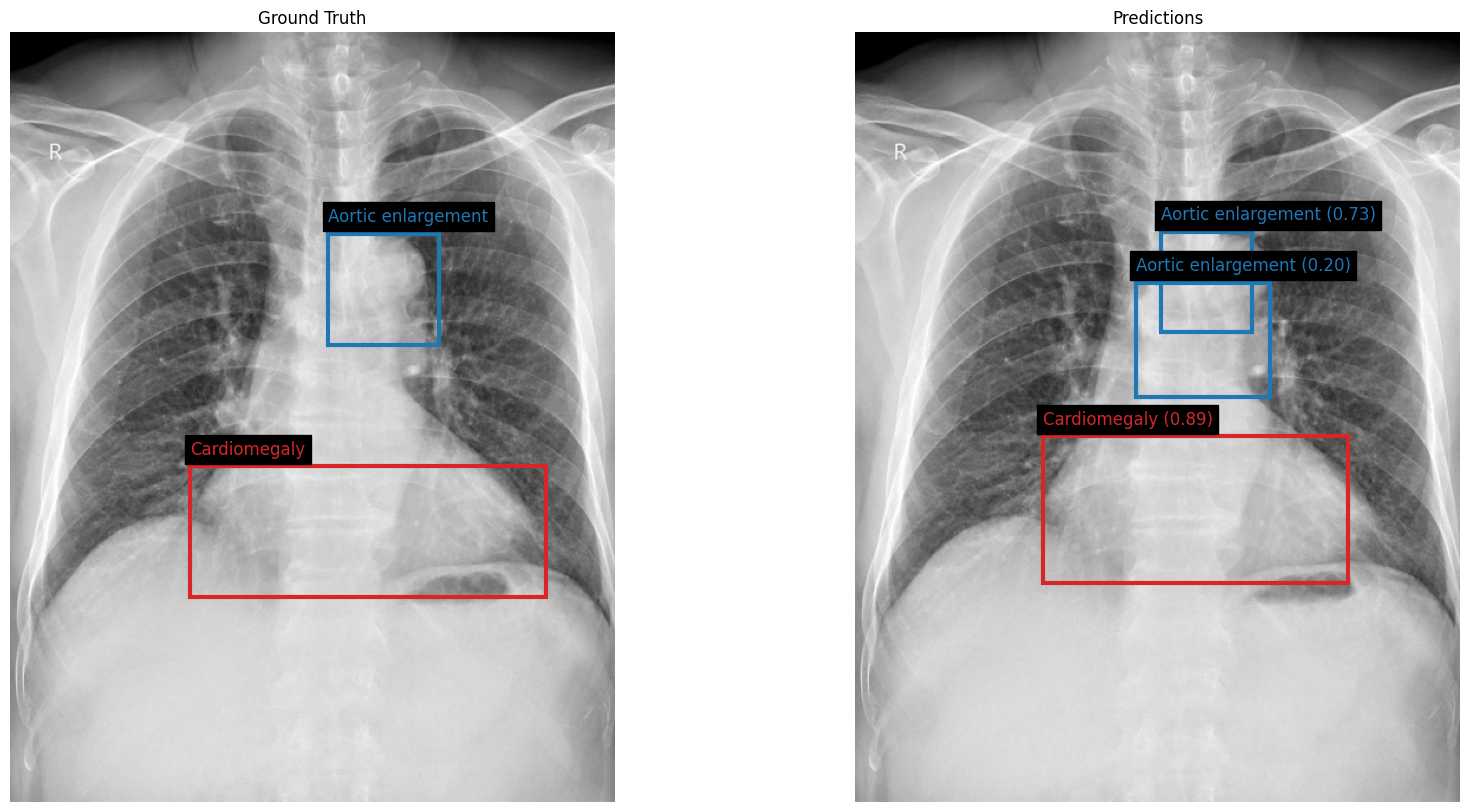

In [149]:
i = 3
# i = 799
i = idxs[i]
# i = tmp['image_paths'].index('/mnt/workspace/vinbig-cxr/dataset-jpg/images_hq-512x512(keep_aspect_ratio)/d01381128975c8bf4dbfd2bf79bd6de1.jpg')
# i = tmp['image_paths'].index('/mnt/workspace/vinbig-cxr/dataset-jpg/images_hq-512x512(keep_aspect_ratio)/9bd79ff85b40084060c327b2b9ca1e81.jpg')
# i = tmp['image_paths'].index('/mnt/workspace/vinbig-cxr/dataset-jpg/images_hq-512x512(keep_aspect_ratio)/5d74f8fd78068c30775dc2c98790e8b9.jpg')
# i = tmp['image_paths'].index('/mnt/workspace/vinbig-cxr/dataset-jpg/images_hq-512x512(keep_aspect_ratio)/e3e51ec366ccdf0b02d1b28f094d9ea9.jpg')
# i = tmp['image_paths'].index('/mnt/workspace/vinbig-cxr/dataset-jpg/images_hq-512x512(keep_aspect_ratio)/1e4029a54dd47b7223885e14cc0e020f.jpg')
# i = tmp['image_paths'].index('/mnt/workspace/vinbig-cxr/dataset-jpg/images_hq-512x512(keep_aspect_ratio)/85718436181b19f2d96683adba71e0fb.jpg')
detection_score(i, tmp, verbose=True)
key = 'bbox_regression'
print(tmp[key]['sample_ious'][i])
visualize_predicted_bounding_boxes__yolo(
    image_path=tmp['image_paths'][i],
    pred_coords=tmp[key]['pred_boxes_list'][i],
    pred_classes=tmp[key]['pred_classes_list'][i],
    pred_confs=tmp[key]['pred_confs_list'][i],
    gt_bbox_coords=tmp[key]['gt_bboxes'][i],
    class_names=bbox_names,
    figsize=(20, 10),
    format='xyxy',
    classes_to_highlight=classes_to_highlight,
    hide_other_classes=True,
    minimum_confidence=0.2,
)

iou_score: 0.304264063261812, prob_score: 0.513067620642045
0.30426407
image_path=/mnt/workspace/vinbig-cxr/dataset-jpg/images_hq-512x512(keep_aspect_ratio)/1e4029a54dd47b7223885e14cc0e020f.jpg


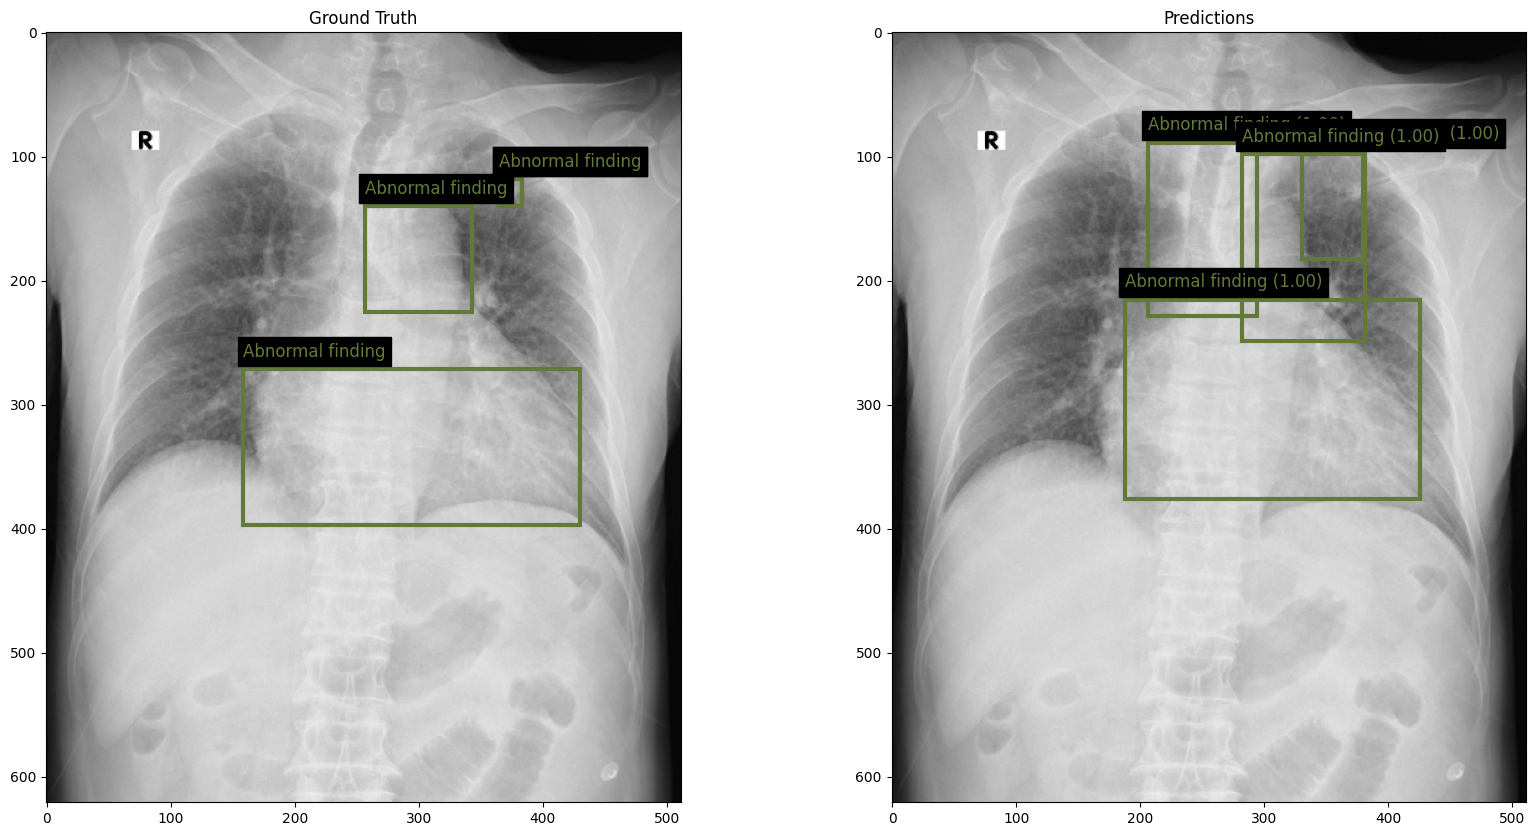

In [130]:
i = 799
# i = 50
i = idxs[i]
# i = tmp['image_paths'].index('/mnt/workspace/vinbig-cxr/dataset-jpg/images_hq-512x512(keep_aspect_ratio)/e3e51ec366ccdf0b02d1b28f094d9ea9.jpg')
i = tmp['image_paths'].index('/mnt/workspace/vinbig-cxr/dataset-jpg/images_hq-512x512(keep_aspect_ratio)/1e4029a54dd47b7223885e14cc0e020f.jpg')
detection_score(i, tmp, verbose=True)
key = 'bbox_regression'
print(tmp[key]['sample_ious'][i])
visualize_predicted_bounding_boxes__yolo(
    image_path=tmp['image_paths'][i],
    pred_coords=tmp[key]['pred_boxes_list'][i],
    pred_classes=tmp[key]['pred_classes_list'][i],
    pred_confs=tmp[key]['pred_confs_list'][i],
    gt_bbox_coords=tmp[key]['gt_bboxes'][i],
    class_names=bbox_names,
    figsize=(20, 10),
    format='xyxy',
    classes_to_highlight=['Abnormal finding'],
    hide_other_classes=True,
#     minimum_confidence=0.2,
)

In [66]:
!python ../eval_phrase_grounding.py \
--checkpoint_folder_path \
"/mnt/data/pamessina/workspaces/medvqa-workspace/models/phrase_grounding/20250214_120748_vinbig_PhraseGrounder(aehrc-cxrmate-rrg24-uniformer,AdaptiveFiLM_MLP_BBoxRegression,128,256,256-128)" \
--num_workers 3 \
--max_images_per_batch 200 \
--max_phrases_per_batch 2000 \
--max_phrases_per_image 30 \
--optimize_thresholds \
--candidate_iou_thresholds 0.05 0.1 0.2 0.3 0.4 0.5 \
--candidate_conf_thresholds 0.1 0.2 0.3 0.4 0.5 \
--use_classifier_confs_for_map \
--eval_vinbig

script's arguments:
   checkpoint_folder_path: /mnt/data/pamessina/workspaces/medvqa-workspace/models/phrase_grounding/20250214_120748_vinbig_PhraseGrounder(aehrc-cxrmate-rrg24-uniformer,AdaptiveFiLM_MLP_BBoxRegression,128,256,256-128)
   max_images_per_batch: 200
   max_phrases_per_batch: 2000
   max_phrases_per_image: 30
   num_workers: 3
   device: GPU
   mscxr_phrase2embedding_filepath: None
   vinbig_use_training_indices_for_validation: False
   checkpoint_folder_path_to_borrow_metadata_from: None
   eval_chest_imagenome_gold: False
   eval_mscxr: False
   eval_chexlocalize: False
   eval_vinbig: True
   optimize_thresholds: True
   candidate_iou_thresholds: [0.05, 0.1, 0.2, 0.3, 0.4, 0.5]
   candidate_conf_thresholds: [0.1, 0.2, 0.3, 0.4, 0.5]
   map_iou_thresholds: [0.0, 0.02, 0.05, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7]
   use_amp: False
   use_classifier_confs_for_map: True
----- Evaluating model -----
metadata loaded from /mnt/data/pamessina/workspaces/medvqa-workspace/models/phr

Using classifier confidences for mAP computation
classifier_confs.shape = (3000, 23)
Finding optimal conf and iou thresholds
conf_th=0.1, iou_th=0.05, mAP=0.2749571276353381 (time_input_processing=2.169494867324829, time_map=4.326600074768066)
conf_th=0.1, iou_th=0.1, mAP=0.2763966005301934 (time_input_processing=2.102100133895874, time_map=4.921199083328247)
conf_th=0.1, iou_th=0.2, mAP=0.2826963651647717 (time_input_processing=2.0780327320098877, time_map=5.25731348991394)
conf_th=0.1, iou_th=0.3, mAP=0.28549627723518195 (time_input_processing=2.078829050064087, time_map=5.849114418029785)
conf_th=0.1, iou_th=0.4, mAP=0.2806335954879622 (time_input_processing=2.0827152729034424, time_map=6.657455921173096)
conf_th=0.1, iou_th=0.5, mAP=0.2820103174124091 (time_input_processing=2.1096832752227783, time_map=7.934997797012329)
conf_th=0.2, iou_th=0.05, mAP=0.2785380156463943 (time_input_processing=1.8897547721862793, time_map=4.101983070373535)
conf_th=0.2, iou_th=0.1, mAP=0.279663216856

In [63]:
!python ../eval_phrase_grounding.py \
--checkpoint_folder_path \
"/mnt/data/pamessina/workspaces/medvqa-workspace/models/phrase_grounding/20250206_105410_mim-facts_PhraseGrounder(aehrc-cxrmate-rrg24-uniformer,AdaptiveFiLM_MLP,128,256,256-128)" \
--num_workers 3 \
--max_images_per_batch 200 \
--max_phrases_per_batch 2000 \
--max_phrases_per_image 30 \
--checkpoint_folder_path_to_borrow_metadata_from \
"/mnt/data/pamessina/workspaces/medvqa-workspace/models/phrase_grounding/20250214_120748_vinbig_PhraseGrounder(aehrc-cxrmate-rrg24-uniformer,AdaptiveFiLM_MLP_BBoxRegression,128,256,256-128)/" \
--eval_vinbig

script's arguments:
   checkpoint_folder_path: /mnt/data/pamessina/workspaces/medvqa-workspace/models/phrase_grounding/20250206_105410_mim-facts_PhraseGrounder(aehrc-cxrmate-rrg24-uniformer,AdaptiveFiLM_MLP,128,256,256-128)
   max_images_per_batch: 200
   max_phrases_per_batch: 2000
   max_phrases_per_image: 30
   num_workers: 3
   device: GPU
   mscxr_phrase2embedding_filepath: None
   vinbig_use_training_indices_for_validation: False
   checkpoint_folder_path_to_borrow_metadata_from: /mnt/data/pamessina/workspaces/medvqa-workspace/models/phrase_grounding/20250214_120748_vinbig_PhraseGrounder(aehrc-cxrmate-rrg24-uniformer,AdaptiveFiLM_MLP_BBoxRegression,128,256,256-128)/
   eval_chest_imagenome_gold: False
   eval_mscxr: False
   eval_chexlocalize: False
   eval_vinbig: True
   optimize_thresholds: False
   candidate_iou_thresholds: None
   candidate_conf_thresholds: None
   map_iou_thresholds: [0.0, 0.02, 0.05, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7]
   use_amp: False
   use_classifier_co

In [38]:
!python ../eval_phrase_grounding.py \
--checkpoint_folder_path \
"/mnt/data/pamessina/workspaces/medvqa-workspace/models/phrase_grounding/20250203_061106_mim-facts_PhraseGrounder(aehrc-cxrmate-rrg24-uniformer,AdaptiveFiLM_MLP,128,256,256-128)" \
--num_workers 3 \
--max_images_per_batch 200 \
--max_phrases_per_batch 2000 \
--max_phrases_per_image 30 \
--checkpoint_folder_path_borrow_metadata_from \
"/mnt/data/pamessina/workspaces/medvqa-workspace/models/phrase_grounding/20250214_120748_vinbig_PhraseGrounder(aehrc-cxrmate-rrg24-uniformer,AdaptiveFiLM_MLP_BBoxRegression,128,256,256-128)/" \
--eval_vinbig

script's arguments:
   checkpoint_folder_path: /mnt/data/pamessina/workspaces/medvqa-workspace/models/phrase_grounding/20250203_061106_mim-facts_PhraseGrounder(aehrc-cxrmate-rrg24-uniformer,AdaptiveFiLM_MLP,128,256,256-128)
   max_images_per_batch: 200
   max_phrases_per_batch: 2000
   max_phrases_per_image: 30
   num_workers: 3
   device: GPU
   mscxr_phrase2embedding_filepath: None
   vinbig_use_training_indices_for_validation: False
   checkpoint_folder_path_borrow_metadata_from: /mnt/data/pamessina/workspaces/medvqa-workspace/models/phrase_grounding/20250214_120748_vinbig_PhraseGrounder(aehrc-cxrmate-rrg24-uniformer,AdaptiveFiLM_MLP_BBoxRegression,128,256,256-128)/
   eval_chest_imagenome_gold: False
   eval_mscxr: False
   eval_chexlocalize: False
   eval_vinbig: True
   optimize_thresholds: False
   candidate_iou_thresholds: None
   candidate_conf_thresholds: None
   map_iou_thresholds: [0.0, 0.02, 0.05, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7]
   use_amp: False
   use_classifier_confs

mAP(micro_avg): 0.42117511033578303
mAP(macro_avg): 0.3759600357837917
Saved metrics to /mnt/data/pamessina/workspaces/medvqa-workspace/results/phrase_grounding/20250203_061106_mim-facts_PhraseGrounder(aehrc-cxrmate-rrg24-uniformer,AdaptiveFiLM_MLP,128,256,256-128)/vindrcxr_metrics(classification,3000).pkl


In [73]:
!python ../eval_phrase_grounding.py \
--checkpoint_folder_path \
"/mnt/data/pamessina/workspaces/medvqa-workspace/models/phrase_grounding/20250215_042300_mim-facts_PhraseGrounder(facebook-convnext-small-224,AdaptiveFiLM_MLP,128,256,256-128)" \
--num_workers 3 \
--max_images_per_batch 200 \
--max_phrases_per_batch 2000 \
--max_phrases_per_image 30 \
--checkpoint_folder_path_to_borrow_metadata_from \
"/mnt/data/pamessina/workspaces/medvqa-workspace/models/phrase_grounding/20250214_120748_vinbig_PhraseGrounder(aehrc-cxrmate-rrg24-uniformer,AdaptiveFiLM_MLP_BBoxRegression,128,256,256-128)/" \
--eval_vinbig

script's arguments:
   checkpoint_folder_path: /mnt/data/pamessina/workspaces/medvqa-workspace/models/phrase_grounding/20250215_042300_mim-facts_PhraseGrounder(facebook-convnext-small-224,AdaptiveFiLM_MLP,128,256,256-128)
   max_images_per_batch: 200
   max_phrases_per_batch: 2000
   max_phrases_per_image: 30
   num_workers: 3
   device: GPU
   mscxr_phrase2embedding_filepath: None
   vinbig_use_training_indices_for_validation: False
   checkpoint_folder_path_to_borrow_metadata_from: /mnt/data/pamessina/workspaces/medvqa-workspace/models/phrase_grounding/20250214_120748_vinbig_PhraseGrounder(aehrc-cxrmate-rrg24-uniformer,AdaptiveFiLM_MLP_BBoxRegression,128,256,256-128)/
   eval_chest_imagenome_gold: False
   eval_mscxr: False
   eval_chexlocalize: False
   eval_vinbig: True
   optimize_thresholds: False
   candidate_iou_thresholds: None
   candidate_conf_thresholds: None
   map_iou_thresholds: [0.0, 0.02, 0.05, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7]
   use_amp: False
   use_classifier_conf

In [40]:
!python ../eval_phrase_grounding.py \
--checkpoint_folder_path \
"/mnt/data/pamessina/workspaces/medvqa-workspace/models/phrase_grounding/20250215_011909_mim-facts_PhraseGrounder(facebook-convnext-small-224,AdaptiveFiLM_MLP,128,256,256-128)" \
--num_workers 3 \
--max_images_per_batch 200 \
--max_phrases_per_batch 2000 \
--max_phrases_per_image 30 \
--checkpoint_folder_path_to_borrow_metadata_from \
"/mnt/data/pamessina/workspaces/medvqa-workspace/models/phrase_grounding/20250214_120748_vinbig_PhraseGrounder(aehrc-cxrmate-rrg24-uniformer,AdaptiveFiLM_MLP_BBoxRegression,128,256,256-128)/" \
--eval_vinbig

script's arguments:
   checkpoint_folder_path: /mnt/data/pamessina/workspaces/medvqa-workspace/models/phrase_grounding/20250215_011909_mim-facts_PhraseGrounder(facebook-convnext-small-224,AdaptiveFiLM_MLP,128,256,256-128)
   max_images_per_batch: 200
   max_phrases_per_batch: 2000
   max_phrases_per_image: 30
   num_workers: 3
   device: GPU
   mscxr_phrase2embedding_filepath: None
   vinbig_use_training_indices_for_validation: False
   checkpoint_folder_path_to_borrow_metadata_from: /mnt/data/pamessina/workspaces/medvqa-workspace/models/phrase_grounding/20250214_120748_vinbig_PhraseGrounder(aehrc-cxrmate-rrg24-uniformer,AdaptiveFiLM_MLP_BBoxRegression,128,256,256-128)/
   eval_chest_imagenome_gold: False
   eval_mscxr: False
   eval_chexlocalize: False
   eval_vinbig: True
   optimize_thresholds: False
   candidate_iou_thresholds: None
   candidate_conf_thresholds: None
   map_iou_thresholds: [0.0, 0.02, 0.05, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7]
   use_amp: False
   use_classifier_conf

mAP(micro_avg): 0.4005193322755013
mAP(macro_avg): 0.329005127139688
Saved metrics to /mnt/data/pamessina/workspaces/medvqa-workspace/results/phrase_grounding/20250215_011909_mim-facts_PhraseGrounder(facebook-convnext-small-224,AdaptiveFiLM_MLP,128,256,256-128)/vindrcxr_metrics(classification,3000).pkl


In [72]:
!python ../eval_phrase_grounding.py \
--checkpoint_folder_path \
"/mnt/data/pamessina/workspaces/medvqa-workspace/models/phrase_grounding/20250215_012801_vinbig_PhraseGrounder(facebook-convnext-small-224,AdaptiveFiLM_MLP_BBoxRegression,128,256,256-128)" \
--num_workers 3 \
--max_images_per_batch 200 \
--max_phrases_per_batch 2000 \
--max_phrases_per_image 30 \
--optimize_thresholds \
--candidate_iou_thresholds 0.05 0.1 0.2 0.3 0.4 0.5 \
--candidate_conf_thresholds 0.1 0.2 0.3 0.4 0.5 \
--use_classifier_confs_for_map \
--eval_vinbig

script's arguments:
   checkpoint_folder_path: /mnt/data/pamessina/workspaces/medvqa-workspace/models/phrase_grounding/20250215_012801_vinbig_PhraseGrounder(facebook-convnext-small-224,AdaptiveFiLM_MLP_BBoxRegression,128,256,256-128)
   max_images_per_batch: 200
   max_phrases_per_batch: 2000
   max_phrases_per_image: 30
   num_workers: 3
   device: GPU
   mscxr_phrase2embedding_filepath: None
   vinbig_use_training_indices_for_validation: False
   checkpoint_folder_path_to_borrow_metadata_from: None
   eval_chest_imagenome_gold: False
   eval_mscxr: False
   eval_chexlocalize: False
   eval_vinbig: True
   optimize_thresholds: True
   candidate_iou_thresholds: [0.05, 0.1, 0.2, 0.3, 0.4, 0.5]
   candidate_conf_thresholds: [0.1, 0.2, 0.3, 0.4, 0.5]
   map_iou_thresholds: [0.0, 0.02, 0.05, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7]
   use_amp: False
   use_classifier_confs_for_map: True
Activating determinism(seed=42)...
----- Evaluating model -----
metadata loaded from /mnt/data/pamessina/works

Using classifier confidences for mAP computation
classifier_confs.shape = (3000, 23)
Finding optimal conf and iou thresholds
conf_th=0.1, iou_th=0.05, mAP=0.2400792505916348 (time_input_processing=2.2156639099121094, time_map=4.018650531768799)
conf_th=0.1, iou_th=0.1, mAP=0.24150784887662663 (time_input_processing=2.1398041248321533, time_map=4.291402339935303)
conf_th=0.1, iou_th=0.2, mAP=0.2420789592374349 (time_input_processing=2.1375925540924072, time_map=4.8071067333221436)
conf_th=0.1, iou_th=0.3, mAP=0.2383112731992439 (time_input_processing=2.1361093521118164, time_map=5.731026887893677)
conf_th=0.1, iou_th=0.4, mAP=0.2382585307921396 (time_input_processing=2.1725339889526367, time_map=6.281222581863403)
conf_th=0.1, iou_th=0.5, mAP=0.23679177209282323 (time_input_processing=2.1406233310699463, time_map=7.388328313827515)
conf_th=0.2, iou_th=0.05, mAP=0.23971045879366332 (time_input_processing=1.953183650970459, time_map=3.809659481048584)
conf_th=0.2, iou_th=0.1, mAP=0.241094

In [68]:
!python ../eval_phrase_grounding.py \
--checkpoint_folder_path \
"/mnt/data/pamessina/workspaces/medvqa-workspace/models/phrase_grounding/20250215_152817_vinbig_PhraseGrounder(microsoft-rad-dino-maira-2,AdaptiveFiLM_MLP_BBoxRegression,128,256,256-128)" \
--num_workers 3 \
--max_images_per_batch 50 \
--max_phrases_per_batch 2000 \
--max_phrases_per_image 30 \
--optimize_thresholds \
--candidate_iou_thresholds 0.05 0.1 0.2 0.3 0.4 0.5 \
--candidate_conf_thresholds 0.1 0.2 0.3 0.4 0.5 \
--use_classifier_confs_for_map \
--eval_vinbig

script's arguments:
   checkpoint_folder_path: /mnt/data/pamessina/workspaces/medvqa-workspace/models/phrase_grounding/20250215_152817_vinbig_PhraseGrounder(microsoft-rad-dino-maira-2,AdaptiveFiLM_MLP_BBoxRegression,128,256,256-128)
   max_images_per_batch: 50
   max_phrases_per_batch: 2000
   max_phrases_per_image: 30
   num_workers: 3
   device: GPU
   mscxr_phrase2embedding_filepath: None
   vinbig_use_training_indices_for_validation: False
   checkpoint_folder_path_to_borrow_metadata_from: None
   eval_chest_imagenome_gold: False
   eval_mscxr: False
   eval_chexlocalize: False
   eval_vinbig: True
   optimize_thresholds: True
   candidate_iou_thresholds: [0.05, 0.1, 0.2, 0.3, 0.4, 0.5]
   candidate_conf_thresholds: [0.1, 0.2, 0.3, 0.4, 0.5]
   map_iou_thresholds: [0.0, 0.02, 0.05, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7]
   use_amp: False
   use_classifier_confs_for_map: True
----- Evaluating model -----
metadata loaded from /mnt/data/pamessina/workspaces/medvqa-workspace/models/phrase_

Using classifier confidences for mAP computation
classifier_confs.shape = (3000, 23)
Finding optimal conf and iou thresholds
conf_th=0.1, iou_th=0.05, mAP=0.27195247109121456 (time_input_processing=2.3384158611297607, time_map=3.3173491954803467)
conf_th=0.1, iou_th=0.1, mAP=0.27182796059044195 (time_input_processing=2.2692618370056152, time_map=3.4324934482574463)
conf_th=0.1, iou_th=0.2, mAP=0.2735012542615917 (time_input_processing=2.272531509399414, time_map=3.5918502807617188)
conf_th=0.1, iou_th=0.3, mAP=0.2730559986115134 (time_input_processing=2.2609286308288574, time_map=4.122735261917114)
conf_th=0.1, iou_th=0.4, mAP=0.27343663970099297 (time_input_processing=2.28279709815979, time_map=4.187369346618652)
conf_th=0.1, iou_th=0.5, mAP=0.2738662866695004 (time_input_processing=2.2854297161102295, time_map=4.678158760070801)
conf_th=0.2, iou_th=0.05, mAP=0.27182842700072024 (time_input_processing=1.9473071098327637, time_map=3.2268285751342773)
conf_th=0.2, iou_th=0.1, mAP=0.2717

In [5]:
compute_f1_scores_with_bootstrapping('/mnt/data/pamessina/workspaces/medvqa-workspace/results/phrase_grounding/20250215_152817_vinbig_PhraseGrounder(microsoft-rad-dino-maira-2,AdaptiveFiLM_MLP_BBoxRegression,128,256,256-128)/vindrcxr_metrics(bbox_regression,3000,opt_thr(0.50,0.10),use_classifier_confs).pkl')

Bootstrapping: 100%|██████████████████████████████████████████████████████████████████| 200/200 [00:28<00:00,  7.13it/s]

F1(Pleural effusion): 0.7698170804835932 ± 0.0312222708000126
F1(Lung tumor): 0.609027290317515 ± 0.044894900189402925
F1(Pneumonia): 0.6883437022887468 ± 0.022163577586681416
F1(Tuberculosis): 0.6778065882766745 ± 0.02804587237660988
F1(Other disease): 0.6750166168311528 ± 0.014568831905673494
F1(No finding): 0.928364281785712 ± 0.004144201204889475
F1(macro_avg): 0.7247292599972323 ± 0.010863464542865747
F1(micro_avg): 0.820036729605745 ± 0.005993598008657164


In [69]:
!python ../eval_phrase_grounding.py \
--checkpoint_folder_path \
"/mnt/data/pamessina/workspaces/medvqa-workspace/models/phrase_grounding/20250215_195417_mim-facts_PhraseGrounder(microsoft-rad-dino-maira-2,AdaptiveFiLM_MLP,128,256,256-128)" \
--num_workers 3 \
--max_images_per_batch 50 \
--max_phrases_per_batch 2000 \
--max_phrases_per_image 30 \
--checkpoint_folder_path_to_borrow_metadata_from \
"/mnt/data/pamessina/workspaces/medvqa-workspace/models/phrase_grounding/20250214_120748_vinbig_PhraseGrounder(aehrc-cxrmate-rrg24-uniformer,AdaptiveFiLM_MLP_BBoxRegression,128,256,256-128)/" \
--eval_vinbig

script's arguments:
   checkpoint_folder_path: /mnt/data/pamessina/workspaces/medvqa-workspace/models/phrase_grounding/20250215_195417_mim-facts_PhraseGrounder(microsoft-rad-dino-maira-2,AdaptiveFiLM_MLP,128,256,256-128)
   max_images_per_batch: 50
   max_phrases_per_batch: 2000
   max_phrases_per_image: 30
   num_workers: 3
   device: GPU
   mscxr_phrase2embedding_filepath: None
   vinbig_use_training_indices_for_validation: False
   checkpoint_folder_path_to_borrow_metadata_from: /mnt/data/pamessina/workspaces/medvqa-workspace/models/phrase_grounding/20250214_120748_vinbig_PhraseGrounder(aehrc-cxrmate-rrg24-uniformer,AdaptiveFiLM_MLP_BBoxRegression,128,256,256-128)/
   eval_chest_imagenome_gold: False
   eval_mscxr: False
   eval_chexlocalize: False
   eval_vinbig: True
   optimize_thresholds: False
   candidate_iou_thresholds: None
   candidate_conf_thresholds: None
   map_iou_thresholds: [0.0, 0.02, 0.05, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7]
   use_amp: False
   use_classifier_confs_

In [46]:
!python ../eval_phrase_grounding.py \
--checkpoint_folder_path \
"/mnt/data/pamessina/workspaces/medvqa-workspace/models/phrase_grounding/20250215_153529_mim-facts_PhraseGrounder(microsoft-rad-dino-maira-2,AdaptiveFiLM_MLP,128,256,256-128)" \
--num_workers 3 \
--max_images_per_batch 50 \
--max_phrases_per_batch 2000 \
--max_phrases_per_image 30 \
--checkpoint_folder_path_to_borrow_metadata_from \
"/mnt/data/pamessina/workspaces/medvqa-workspace/models/phrase_grounding/20250214_120748_vinbig_PhraseGrounder(aehrc-cxrmate-rrg24-uniformer,AdaptiveFiLM_MLP_BBoxRegression,128,256,256-128)/" \
--eval_vinbig

script's arguments:
   checkpoint_folder_path: /mnt/data/pamessina/workspaces/medvqa-workspace/models/phrase_grounding/20250215_153529_mim-facts_PhraseGrounder(microsoft-rad-dino-maira-2,AdaptiveFiLM_MLP,128,256,256-128)
   max_images_per_batch: 50
   max_phrases_per_batch: 2000
   max_phrases_per_image: 30
   num_workers: 3
   device: GPU
   mscxr_phrase2embedding_filepath: None
   vinbig_use_training_indices_for_validation: False
   checkpoint_folder_path_to_borrow_metadata_from: /mnt/data/pamessina/workspaces/medvqa-workspace/models/phrase_grounding/20250214_120748_vinbig_PhraseGrounder(aehrc-cxrmate-rrg24-uniformer,AdaptiveFiLM_MLP_BBoxRegression,128,256,256-128)/
   eval_chest_imagenome_gold: False
   eval_mscxr: False
   eval_chexlocalize: False
   eval_vinbig: True
   optimize_thresholds: False
   candidate_iou_thresholds: None
   candidate_conf_thresholds: None
   map_iou_thresholds: [0.0, 0.02, 0.05, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7]
   use_amp: False
   use_classifier_confs_

mAP(micro_avg): 0.24455921146865517
mAP(macro_avg): 0.2054705513224395
Saved metrics to /mnt/data/pamessina/workspaces/medvqa-workspace/results/phrase_grounding/20250215_153529_mim-facts_PhraseGrounder(microsoft-rad-dino-maira-2,AdaptiveFiLM_MLP,128,256,256-128)/vindrcxr_metrics(classification,3000).pkl
